In [1]:
%ls
%run DataAndEnvironment.ipynb

data@  DataAndEnvironment.ipynb  README.md  VolRen.ipynb
2269
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
23389
['data/ChestXRLungSegmentation/VinDr/v1/processed/train/images/000434271f63a053c4128a0ba6352c7f.png']
2269
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
5077
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']
2269
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
5077
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
cameras = RandomCameras(batch_size=hparams.batch_size, random=True).to(device)

# render_size describes the size of both sides of the 
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = hparams.shape

# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 4.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=512,
    min_depth=0.001,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# each ray into a single 3D color vector 
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, 
    raymarcher=raymarcher,
)

# Instantiate the volumetric model.
# We use a cubical volume with the size of 
# one side = 128. The size of each voxel of the volume 
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = hparams.shape
volume_model = VolumeModel(
    renderer,
    volume_size = [volume_size] * 3, 
    voxel_size = volume_extent_world / volume_size,
).to(device)


debug_data = first(datamodule.train_dataloader())
image3d = debug_data['image3d'].to(device)
volumes = Volumes(
    features = torch.cat([image3d]*3, dim=1),
    densities = torch.ones_like(image3d) / 1000., 
    voxel_size = volume_extent_world / volume_size,
)

DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.


In [3]:
screens = volume_model(cameras=cameras, volumes=volumes)

R is not a valid rotation matrix


In [4]:
print(screens.shape)

torch.Size([1, 1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

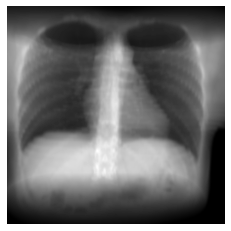

In [5]:
plt.imshow(screens[0,0,:,:].detach().cpu().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')